In [1]:
# Test Notebook
# Imports

import os
import ast
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
# Download PTB-XL Dataset
PTBXL_URL = "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip"

def download_ptbxl(data_dir="data/raw", unzip=True, overwrite=False):
    data_path = Path(data_dir)
    zip_path = data_path / "ptbxl.zip"
    extract_path = data_path / "ptbxl"

    data_path.mkdir(parents=True, exist_ok=True)

    if extract_path.exists() and not overwrite:
        print(f"Dataset already exists at {extract_path}. Skipping download.")
        return extract_path

    if not zip_path.exists() or overwrite:
        print(f"Downloading PTB-XL dataset to {zip_path}...")
        response = requests.get(PTBXL_URL, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024

        with open(zip_path, 'wb') as f, tqdm(total=total_size, unit='iB', unit_scale=True, desc="Downloading") as bar:
            for chunk in response.iter_content(chunk_size=block_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        print("Download complete.")

    if unzip:
        try:
            print(f"Extracting PTB-XL dataset to {extract_path}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print("Extraction complete.")
        except zipfile.BadZipFile:
            print("Corrupted zip file detected. Deleting and retrying...")
            zip_path.unlink()
            return download_ptbxl(data_dir, unzip, overwrite=True)

    return extract_path

In [3]:
# Auto Shape fix

class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path)
        # This ensures all output is [12, 5000] (channels, time)
        if signal.shape[1] == 12:
            signal = signal.T
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [4]:
# Setup paths
dataset_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
ptbxl_path = dataset_path / "ptbxl_database.csv"
waveform_path = dataset_path

# Load dataframe
df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'AFIB', 'PVC', 'LVH', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]

mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Helper: load ECG
def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal  # shape: [5000, 12]

# PyTorch Dataset
class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T  # [12, 5000]
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# KFold for Transformer Models

kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
afib_idx = target_labels.index('AFIB')

for fold, (train_idx, val_idx) in enumerate(kf.split(df, y)):
   
    # Split data
    X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # OVERSAMPLE AFIB in training set 
    afib_mask = y_train[:, afib_idx] == 1
    X_train_afib = X_train[afib_mask]
    y_train_afib = y_train[afib_mask]

    # Oversample AFIB rows (here: double, adjust multiplier as needed)
    X_train_oversampled = pd.concat([X_train, X_train_afib])
    y_train_oversampled = np.concatenate([y_train, y_train_afib])

    # Shuffle after oversampling
    shuffler = np.random.permutation(len(X_train_oversampled))
    X_train_oversampled = X_train_oversampled.iloc[shuffler]
    y_train_oversampled = y_train_oversampled[shuffler]



train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [5]:
# Transformer model Definition
class ECG_Transformer(nn.Module):
    def __init__(self, seq_len=5000, num_features=12, d_model=32, nhead=2, num_layers=2, num_classes=8):
        super(ECG_Transformer, self).__init__()
        self.input_linear = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.input_linear(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.fc(x)
        return x
        pass
        
# Transformer CCN Model Definition
class ECG_Transformer_CNN(nn.Module):
    def __init__(self, seq_len=5000, num_features=12, d_model=32, nhead=2, num_layers=2, num_classes=8):
        super(ECG_Transformer_CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=d_model, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        return self.fc(x)
        pass

# xResNet1D Model Definition
class ConvLayer(nn.Sequential):
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, act_cls=nn.ReLU):
        if padding is None: padding = (ks - 1) // 2
        conv = nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias or False)
        bn = nn.BatchNorm1d(nf)
        layers = [conv, bn]
        if act_cls is not None:
            layers.append(act_cls())
        super().__init__(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.convs = nn.Sequential(
            ConvLayer(ni, nf, stride=stride),
            ConvLayer(nf, nf, act_cls=None)
        )
        self.idconv = nn.Identity() if ni == nf and stride == 1 else ConvLayer(ni, nf, ks=1, stride=stride, act_cls=None)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.convs(x) + self.idconv(x))

class XResNet1d(nn.Sequential):
    def __init__(self, layers, input_channels=12, num_classes=10):
        self.block_sizes = [64, 128, 256, 512]
        stem = [ConvLayer(input_channels, 64, ks=7, stride=2), nn.MaxPool1d(kernel_size=3, stride=2, padding=1)]
        blocks = []
        ni = 64
        for i, n_blocks in enumerate(layers):
            nf = self.block_sizes[i]
            for j in range(n_blocks):
                stride = 2 if j == 0 and i != 0 else 1
                blocks.append(ResBlock(ni, nf, stride=stride))
                ni = nf
        head = [nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(ni, num_classes)]
        super().__init__(*stem, *blocks, *head)
        pass

# xLSTM Model Definition
class xLSTMECG(nn.Module):
    def __init__(self, input_channels=12, num_classes=10, hidden_size=128, num_layers=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)  # [B, T, C]
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last time step
        return self.fc(x)
        pass

# ResNet1D Model Definition

class BasicBlock1d(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet1d(nn.Module):
    def __init__(self, block, layers, in_channels=12, num_classes=10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion)
            )
        layers = [block(self.inplanes, planes, stride, downsample=downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).squeeze(-1)
        return self.fc(x)

In [6]:
# Model Selector 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Uncomment ONE model you want to use ===


# model = ResNet1d(BasicBlock1d, [2, 2, 2, 2], in_channels=12, num_classes=len(target_labels))

model = XResNet1d([2, 2, 2, 2], input_channels=12, num_classes=len(target_labels)).to(device)

# model = xLSTMECG(input_channels=12, num_classes=len(target_labels)).to(device)

# model = ECG_Transformer(num_classes=len(target_labels)).to(device)

# model = ECG_Transformer_CNN(num_classes=len(target_labels)).to(device)



In [8]:
# Move the model to the device
model = model.to(device)

# Training setup
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
afib_index = target_labels.index('AFIB')  # Add this if you want to use a custom AFIB threshold

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute predictions with thresholding
        probs = torch.sigmoid(outputs)
        preds = torch.zeros_like(probs)
        # Custom threshold for AFIB
        preds[:, afib_index] = (probs[:, afib_index] > 0.3).float()
        # Default threshold for all other classes
        for i in range(probs.shape[1]):
            if i != afib_index:
                preds[:, i] = (probs[:, i] > 0.5).float()

        total_correct += (preds == labels).float().sum().item()
        total_samples += preds.numel()

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10: 100%|██████████| 1791/1791 [00:42<00:00, 42.10it/s]


Epoch 1, Loss: 0.1088, Accuracy: 0.9551


Epoch 2/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.30it/s]


Epoch 2, Loss: 0.1042, Accuracy: 0.9574


Epoch 3/10: 100%|██████████| 1791/1791 [00:42<00:00, 41.84it/s]


Epoch 3, Loss: 0.0983, Accuracy: 0.9597


Epoch 4/10: 100%|██████████| 1791/1791 [00:40<00:00, 43.88it/s]


Epoch 4, Loss: 0.0963, Accuracy: 0.9612


Epoch 5/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.26it/s]


Epoch 5, Loss: 0.0896, Accuracy: 0.9640


Epoch 6/10: 100%|██████████| 1791/1791 [00:40<00:00, 44.61it/s]


Epoch 6, Loss: 0.0845, Accuracy: 0.9663


Epoch 7/10: 100%|██████████| 1791/1791 [00:43<00:00, 41.35it/s]


Epoch 7, Loss: 0.0793, Accuracy: 0.9678


Epoch 8/10: 100%|██████████| 1791/1791 [00:43<00:00, 41.12it/s]


Epoch 8, Loss: 0.0748, Accuracy: 0.9698


Epoch 9/10: 100%|██████████| 1791/1791 [00:44<00:00, 40.68it/s]


Epoch 9, Loss: 0.0678, Accuracy: 0.9731


Epoch 10/10: 100%|██████████| 1791/1791 [00:43<00:00, 40.86it/s]

Epoch 10, Loss: 0.0622, Accuracy: 0.9756


In [9]:
# Evaluation

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.95      0.97      0.96      1920
        AFIB       0.96      0.98      0.97       309
         PVC       0.95      0.97      0.96       219
         LVH       0.81      0.91      0.86       436
         IMI       0.84      0.89      0.86       520
        ASMI       0.88      0.94      0.91       490
        LAFB       0.97      0.76      0.85       324
       IRBBB       0.89      0.86      0.87       209

   micro avg       0.91      0.93      0.92      4427
   macro avg       0.90      0.91      0.91      4427
weighted avg       0.91      0.93      0.92      4427
 samples avg       0.92      0.94      0.93      4427

Macro ROC-AUC: 0.9915791433043171


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


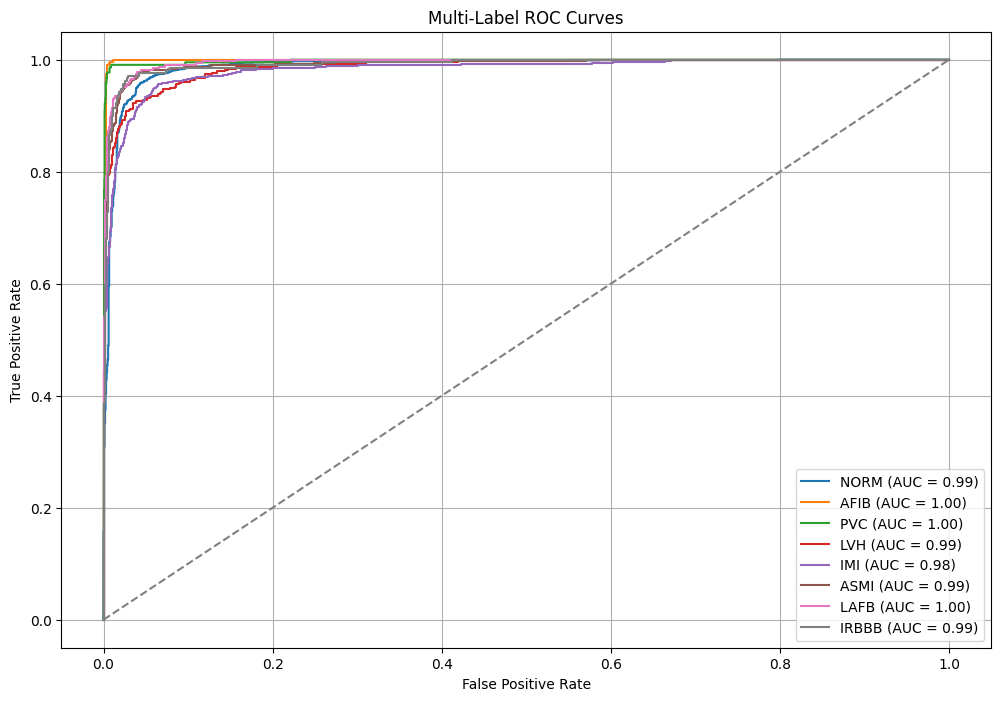

In [10]:
# ROC Curves

plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()